In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.constants import m_e, m_p, pi

fsize = 12

mi = m_p*39.948  # argon

def phi_Te(g):
    return g/(g-1)*( 1 - (2*pi*g*m_e/mi)**((g-1)/(g+1)))


In [4]:
from scipy.optimize import fsolve

def eq(g, chi, f=1):
    return (1 + chi )*(1-chi)**((g-1)/2) - (2*f*np.pi*g*m_e/mi)**((g-1)/2)
    
def dphi(g, f=1):
    chi_initial_guess = -2
    chi_solution = fsolve(lambda c:eq(g,c,f), chi_initial_guess)[0]
    return -chi_solution*g/(g-1)

In [5]:
gvect = np.linspace(1.000001,2.5,100)
dphivect = np.array([ dphi(g) for g in gvect])
plt.style.use("presentation")

/home/tavant/these/code/venv/stand/lib64/python3.7/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


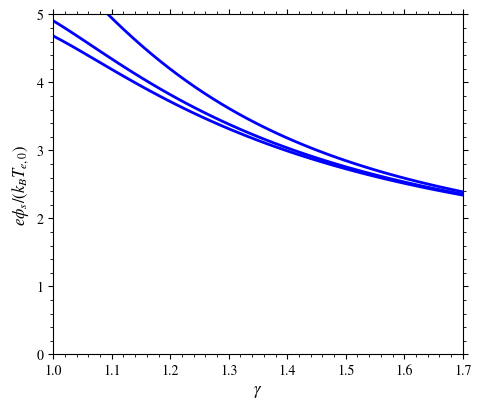

In [6]:
f, ax = plt.subplots(1, 1, figsize = (6.4, 4))
plt.subplots_adjust(left=0.2, bottom=0.12, right=0.84, top=0.97, wspace=0.0, hspace=.0)

for f in [0.1, 0.64, 1]:
    dphivect = np.array([ dphi(g, f=f) for g in gvect])
    
    ax.plot(gvect, dphivect, '-b', linewidth = 2, label="new")


ax.set_xlabel("$\gamma$", fontsize = fsize)
ax.set_ylabel("$e\phi_s / (k_B T_{e,0})$", fontsize = fsize)
ax.set_ylim(0,5)
ax.set_xlim(1,1.7)
ax.grid()


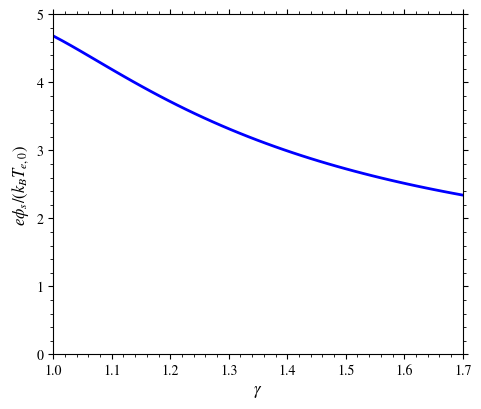

In [7]:

f, ax = plt.subplots(1, 1, figsize = (6.4, 4))
plt.subplots_adjust(left=0.2, bottom=0.12, right=0.84, top=0.97, wspace=0.0, hspace=.0)

ax.plot(gvect, dphivect, '-b', linewidth = 2, label="new")
ax.set_xlabel("$\gamma$", fontsize = fsize)
ax.set_ylabel("$e\phi_s / (k_B T_{e,0})$", fontsize = fsize)
ax.set_ylim(0,5)
ax.set_xlim(1,1.7)
ax.grid()
# plt.savefig("../figures/phinorm_theory.pdf")

# PIC values

In [8]:
from astropy.constants import m_e, e, k_B, m_p
from scipy.constants import pi
k = k_B.value
me = m_e.value
q = e.value
mi = 40* m_p
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook


import json
with open("PIC_data.dat", "r") as f:
    pass
with open("NewPic1D.dat", "r") as f:

    data = json.load(f)

In [9]:
def findPhi(k='0'):
    Te = np.array(data[k]["Te2"])
    phi = np.array(data[k]["phi"])
    ne = np.array(data[k]["ne"])
    ni = np.array(data[k]["ni"])

    indexsheath = np.argwhere(np.abs(ni - ne)/ne.mean() < 0.1)[0][0]
    
    phinorm = phi/Te
    print(indexsheath, phinorm[indexsheath])

for k in ["0","1","2", "3"]:
    findPhi(k)

21 2.036808379552209
25 2.668183051685068
22 2.83213966202231
24 2.3983785028441584


In [10]:
def gammaofK(k):
    """Fit the polytropic coef"""
    Te = np.array(data[k]["Te2"])
    ne = np.array(data[k]["ne"])
             
    ln_n = np.log(ne/ne.max())
    ln_p = np.log((ne*Te)/(ne*Te).max())
    
    gamma, a = np.polyfit(ln_n, ln_p, 1)
    return gamma

def indexUb(k):
    """return the best index for the modified bhom criteriom"""
    Te = np.array(data[k]["Te2"])
    Ji = np.array(data[k]["Ji"])
    ni = np.array(data[k]["ni"])
    
    # E = np.gradient(phi,x*0.01)  # electrif field in V/m
    vi = Ji/(ni * q)
             
    gamma = gammaofK(k)
    
    ub = np.sqrt(gamma*q*Te/mi.value)
                 
    tmp = np.argmin(np.abs(np.abs(vi) -ub)[:len(ni)//2])
    return tmp

def indexquasineutral(k, rtol = 0.1):
    """return the best index for the quisineutrality"""
    ne = np.array(data[k]["ne"])
    ni = np.array(data[k]["ni"])
    
    tmp = np.argwhere(np.abs(ni - ne)/ne.mean()< rtol)[0][0]
    print(tmp)
    return tmp


In [11]:
k = "0"
Te = np.array(data[k]["Te2"])
ne = np.array(data[k]["ne"])
Ji = np.array(data[k]["Ji"])
ni = np.array(data[k]["ni"])
phi = np.array(data[k]["phi"])

# E = np.gradient(phi,x*0.01)  # electrif field in V/m
vi = Ji/(ni * q)
gamma = gammaofK(k)

ub = np.sqrt(gamma*q*Te/mi.value)

In [12]:
klist = ['0','1','2',"3","4", "5"]
Nk = len(klist)
simu_gamma = np.zeros(Nk)
simu_phiUb = np.zeros(Nk)
simu_phiqn = np.zeros(Nk)

for i,k in enumerate(klist):
    
    simu_gamma[i] = gammaofK(k)
    
    Te = np.array(data[k]["Te2"])
    phi = np.array(data[k]["phi"]) 
    
    phinorm = phi/Te

    i1 = indexUb(k)
    
    simu_phiUb[i] = phinorm[i1]
    
    i2 = indexquasineutral(k, rtol=0.05)
    
    simu_phiqn[i] = phinorm[i2]

    
print(simu_gamma)
print(simu_phiUb)
theo =  np.array([ dphi(g) for g in simu_gamma])
print(theo)

print(np.mean((simu_phiUb - 4.68)/4.68*100))
print(np.mean((simu_phiUb -theo)/4.68*100))

print((simu_phiqn - 4.68)/4.68*100)
print((simu_phiqn - theo)/theo*100)

32
35
35
35
30
31
[1.60774597 1.42276904 1.41329905 1.48180213 1.6843951  1.43433611]
[2.16713776 2.77992421 2.93037006 2.52735817 2.02506381 3.30784214]
[2.50046054 2.92673899 2.95339359 2.77221979 2.36640838 2.89490689]
-43.95407354850414
-2.4089459759499285
[-55.00044028 -41.55422562 -36.98190391 -47.1381229  -57.90238845
 -24.37981352]
[-15.77633944  -6.54232414  -0.14040429 -10.75975092 -16.74436921
  22.2500364 ]


<IPython.core.display.Javascript object>


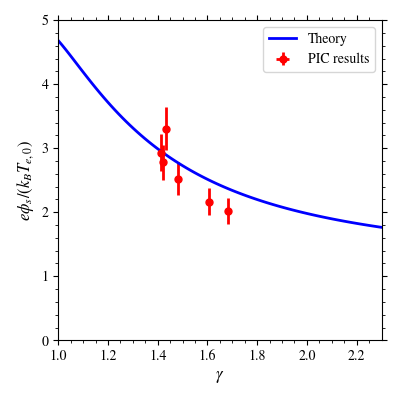

/home/tavant/these/code/venv/stand/lib64/python3.7/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


In [13]:
f, ax = plt.subplots(1, 1, figsize = (4, 4))
plt.subplots_adjust(left=0.2, bottom=0.12, right=0.84, top=0.97, wspace=0.0, hspace=.0)

ax.plot(gvect, dphivect, '-b', linewidth = 2, label="Theory")
ax.errorbar(simu_gamma, simu_phiUb, yerr=0.1*simu_phiUb, xerr=0.0*simu_gamma,
            ls="", marker="o",c="r", label="PIC results")

if False:
    ax.errorbar(simu_gamma, simu_phiqn, yerr=0.1*simu_phiqn, xerr=0.05*simu_gamma,
                ls="", marker="o",c="g", label="PIC quasiNeutrality")

ax.set_xlabel("$\gamma$", fontsize = fsize)
ax.set_ylabel("$e\phi_s / (k_B T_{e,0})$", fontsize = fsize)
ax.set_ylim(0,5)
ax.set_xlim(1,2.3)
ax.grid()
ax.legend()
plt.tight_layout()
plt.savefig("../figures/phinorm_theoryAndPIC.pdf")

# Fitting

In [14]:
from scipy import optimize
%matplotlib notebook

<IPython.core.display.Javascript object>


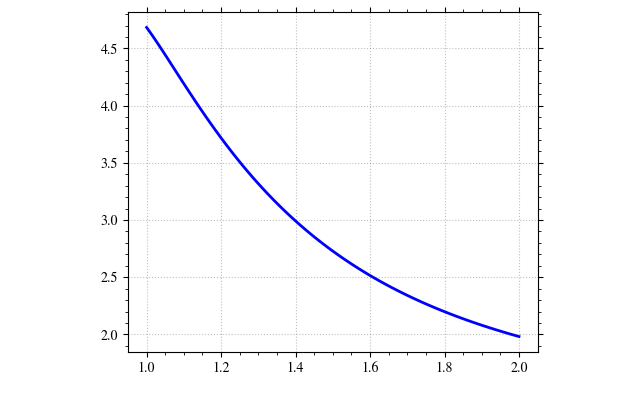

In [15]:
gvect = np.linspace(1.000001,2,120)
dphivect = np.array([ dphi(g) for g in gvect])

f, ax = plt.subplots(1, 1, figsize = (6.4, 4))
plt.subplots_adjust(left=0.2, bottom=0.12, right=0.84, top=0.97, wspace=0.0, hspace=.0)

ax.plot(gvect, dphivect, '-b', linewidth = 2, label="Theory")

In [14]:

def test_func(x, a, b,c):
    return a + b/x**c

x_data = np.array(gvect)
y_data = np.array(dphivect)
params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,
                                               p0=[2, 2,1])
ax.plot(x_data, test_func(x_data, *params),
         label='Fitted function')

params = [0.7, 4.1, 1.7]
ybar = y_data.mean()
sstot = ((y_data - ybar)**2).sum()
ssreg = ((test_func(x_data, *params) - ybar)**2).sum()
print(ssreg / sstot)

1.0117832931409412


# Electron mean energy

In [18]:
from astropy import units as u

In [19]:
with open("ICP_data.dat", "r") as f:
    dataICP = json.load(f)
klist = ['0']

with open("NewPic1D.dat", "r") as f:
     data = json.load(f)
klist = ['0','1','2',"3","4","ICP"]

data["ICP"] = dataICP["0"]


In [20]:
Nk = len(klist)
simu_v = np.zeros(Nk)
simu_e = np.zeros(Nk)
simu_gamma = np.zeros(Nk)

for i,k in enumerate(klist):
    simu_gamma[i] = gammaofK(k)
    Te = np.array(data[k]["Te2"])
    phi = np.array(data[k]["phi"]) 
    
    phinorm = phi/Te

    i1 = indexUb(k)
    Te0 = Te[i1]
    simu_v[i] = ((data[k]["vwall"]*u.m/u.s)**2/(Te0*u.eV) *m_e).decompose()/2
    simu_e[i] = (data[k]["energwall"]*u.eV/(Te0*u.eV)).decompose()
    print( data[k]["energwall"], Te0)

8.901749658584595 2.4069786071777344
7.030949449539184 2.137514114379883
4.484297180175782 1.6382825374603271
7.7249796152114865 2.3553338050842285
9.745967245101928 2.2794528007507324
8.798415279388427 3.2825191020965576


<IPython.core.display.Javascript object>


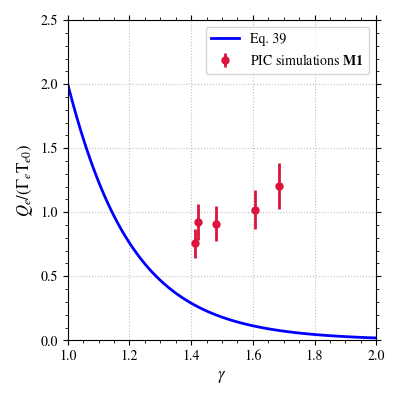

In [25]:
f, ax = plt.subplots(1, 1, figsize = (4, 4))
plt.subplots_adjust(left=0.2, bottom=0.12, right=0.84, top=0.97, wspace=0.0, hspace=.0)

ax.plot(gvect,2*( 1 - (gvect-1)/gvect*dphivect), '-b', linewidth = 2, label="Eq. 39")
#ax.plot(simu_gamma,simu_v, 'ko', linewidth = 2, label="PIC simulations")
ax.errorbar(simu_gamma[:-1],simu_v[:-1],yerr=0.15*simu_v[:-1],c="crimson", fmt="o", label="PIC simulations ${\\bf M1}$")
#ax.errorbar(simu_gamma[:-1],simu_e[:-1]/3,yerr=0.15*simu_v[:-1],c="b", fmt="o", label="PIC simulations ${\\bf M1}$")
#ax.errorbar(simu_gamma[-1:],simu_v[-1:],yerr=0.15*simu_v[-1:],c="b", fmt="o", label="PIC simuations ${\\bf M2}$")
#ax.errorbar(simu_gamma,simu_e,yerr=0.15*simu_v,c="b", fmt="o", label="PIC simuations (E)")

ax.set_xlabel("$\gamma$", fontsize = fsize)
ax.set_ylabel("$Q_e/(\Gamma_e {\\rm T}_{e0})$", fontsize = fsize)
ax.set_ylim(0,2.5)
ax.set_xlim(1,2)
ax.grid()
ax.legend()
plt.grid()
plt.tight_layout()
plt.savefig("../figures/meanelectronenergy_PIC.pdf")

In [20]:
f, ax = plt.subplots(1, 1, figsize = (3.5, 3.5))
plt.subplots_adjust(left=0.2, bottom=0.12, right=0.84, top=0.97, wspace=0.0, hspace=.0)

ax.plot(gvect,2*( 1 - (gvect-1)/gvect*dphivect), '-b', linewidth = 2, label="Eq. 38")

ax.set_xlabel("polytropic index $\gamma$", fontsize = fsize)
ax.set_ylabel("$Q_e/(\Gamma_e T_{e,0})$", fontsize = fsize)
ax.set_ylim(0,2.5)
ax.set_xlim(1,2)
ax.grid()
ax.legend()
plt.grid()
plt.tight_layout()
plt.savefig("../figures/meanelectronenergy.pdf")

<IPython.core.display.Javascript object>